In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import datetime
import xlrd
import os
import re
from scipy.stats import kstest
from scipy.spatial.distance import directed_hausdorff
from scipy import optimize
import pwlf
from scipy.optimize import minimize
from pyecharts import options as opts
from pyecharts.charts import Calendar
from matplotlib.ticker import FuncFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df1_1 = pd.read_csv('kcf_9_floor1.csv')
df1_1 = df1_1.drop(df1_1.columns[[0]], axis = 1).reset_index(drop=True)
df1_2 = pd.read_csv('kcf_9_floor2.csv')
df1_2 = df1_2.drop(df1_2.columns[[0]], axis = 1).reset_index(drop=True)
df1_3 = pd.read_csv('kcf_9_floor3.csv')
df1_3 = df1_3.drop(df1_3.columns[[0]], axis = 1).reset_index(drop=True)
df2_1 = pd.read_csv('klt_9_floor1.csv')
df2_1 = df2_1.drop(df2_1.columns[[0]], axis = 1).reset_index(drop=True)
df2_2 = pd.read_csv('klt_9_floor2.csv')
df2_2 = df2_2.drop(df2_2.columns[[0]], axis = 1).reset_index(drop=True)
df2_3 = pd.read_csv('klt_9_floor3.csv')
df2_3 = df2_3.drop(df2_3.columns[[0]], axis = 1).reset_index(drop=True)
df3_1 = pd.read_csv('mf_9_floor1.csv')
df3_1 = df3_1.drop(df3_1.columns[[0]], axis = 1).reset_index(drop=True)
df3_2 = pd.read_csv('mf_9_floor2.csv')
df3_2 = df3_2.drop(df3_2.columns[[0]], axis = 1).reset_index(drop=True)
df3_3 = pd.read_csv('mf_9_floor3.csv')
df3_3 = df3_3.drop(df3_3.columns[[0]], axis = 1).reset_index(drop=True)

In [3]:
def loss(target, prediction):
    if np.isnan(target).all() or np.isnan(prediction).all():
        return 0, 0, 0, 0
    from math import sqrt
    error = []
    pError = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
        if abs(target[i]) + abs(prediction[i]) == 0:
            pError.append(0)
        else:
            pError.append(abs(target[i] - prediction[i]) / ((abs(target[i]) + abs(prediction[i]))/2))

    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)#target-prediction之差平方 
        absError.append(abs(val))#误差绝对值
    mse = sum(squaredError) / len(squaredError)#均方误差MSE
    rmse = sqrt(sum(squaredError) / len(squaredError))#均方根误差RMSE
    mae = sum(absError) / len(absError)#平均绝对误差MAE
    smape = sum(pError) / len(absError)
    return mse, rmse, mae, smape

In [4]:
def train():
    df1 = pd.concat([df1_1, df1_2, df1_3]).reset_index(drop=True)
    df2 = pd.concat([df2_1, df2_2, df2_3]).reset_index(drop=True)
    df3 = pd.concat([df3_1, df3_2, df3_3]).reset_index(drop=True)
    df = pd.DataFrame()
    df['kcf'] = df1['pred']
    df['klt'] = df2['pred']
    df['mf'] = df3['pred']
    df['real'] = df1['real']
    y = df.values[:,-1]
    x = df.values[:,:-1]
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model.fit(x,y)
    return model
model = train()

[23:37:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [10]:
def test(df1, df2, df3, model):
    df = pd.DataFrame()
    df['kcf'] = df1['pred']
    df['klt'] = df2['pred']
    df['mf'] = df3['pred']
    df['real'] = df1['real']
    real = df.values[:,-1]
    x = df.values[:,:-1]
    pred = model.predict(x)
    plt.plot(df1['pred'], label='kcf')
    plt.plot(df2['pred'], label='klt')
    plt.plot(df3['pred'], label='mf')
    plt.plot(pred, label='xgboost ensemble')
    plt.plot(real, label='real')
    plt.legend()
    plt.xlabel('time/s')
    plt.ylabel('disp/mm')
    plt.title('third floor xgboost ensemble displacement')
    plt.show()
    mse, rmse, mae, smape = loss(real, pred)
    return mse, rmse, mae, smape

In [6]:
tdf1_1 = pd.read_csv('kcf_8_floor1.csv')
tdf1_1 = tdf1_1.drop(tdf1_1.columns[[0]], axis = 1).reset_index(drop=True)
tdf1_2 = pd.read_csv('kcf_8_floor2.csv')
tdf1_2 = tdf1_2.drop(tdf1_2.columns[[0]], axis = 1).reset_index(drop=True)
tdf1_3 = pd.read_csv('kcf_8_floor3.csv')
tdf1_3 = tdf1_3.drop(tdf1_3.columns[[0]], axis = 1).reset_index(drop=True)
tdf2_1 = pd.read_csv('klt_8_floor1.csv')
tdf2_1 = tdf2_1.drop(tdf2_1.columns[[0]], axis = 1).reset_index(drop=True)
tdf2_2 = pd.read_csv('klt_8_floor2.csv')
tdf2_2 = tdf2_2.drop(tdf2_2.columns[[0]], axis = 1).reset_index(drop=True)
tdf2_3 = pd.read_csv('klt_8_floor3.csv')
tdf2_3 = tdf2_3.drop(tdf2_3.columns[[0]], axis = 1).reset_index(drop=True)
tdf3_1 = pd.read_csv('mf_8_floor1.csv')
tdf3_1 = tdf3_1.drop(tdf3_1.columns[[0]], axis = 1).reset_index(drop=True)
tdf3_2 = pd.read_csv('mf_8_floor2.csv')
tdf3_2 = tdf3_2.drop(tdf3_2.columns[[0]], axis = 1).reset_index(drop=True)
tdf3_3 = pd.read_csv('mf_8_floor3.csv')
tdf3_3 = tdf3_3.drop(tdf3_3.columns[[0]], axis = 1).reset_index(drop=True)

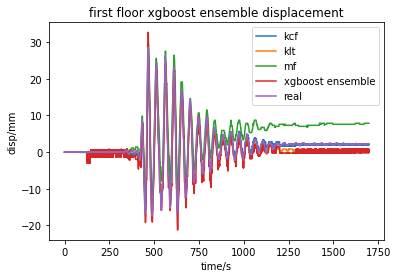

(3.97930184391824, 1.9948187496407388, 1.5783946677602798, 1.1469287114452025)

In [7]:
test(tdf1_1, tdf2_1, tdf3_1, model)

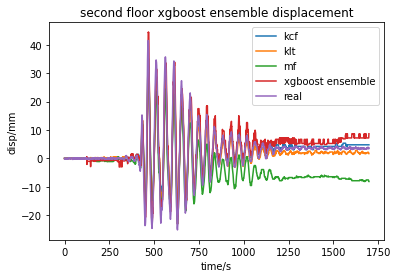

(9.05325054972152, 3.0088620024390482, 2.3231162345689826, 0.827654997790796)

In [9]:
test(tdf1_2, tdf2_2, tdf3_2, model)

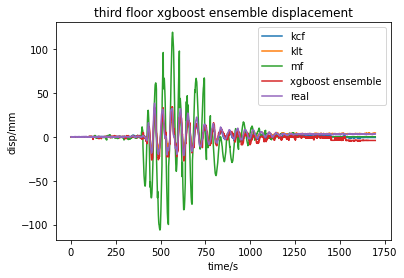

(20.042426019032966, 4.476876815262283, 3.5048191315285484, 1.391678445274185)

In [11]:
test(tdf1_3, tdf2_3, tdf3_3, model)

In [25]:
def train1():
    df1 = df1_1
    df2 = df2_1
    df3 = df3_1
    df = pd.DataFrame()
    df['kcf'] = df1['pred']
    df['klt'] = df2['pred']
    df['mf'] = df3['pred']
    df['real'] = df1['real']
    y = df.values[:,-1]
    x = df.values[:,:-1]
    model = xgb.XGBRegressor()
    model.fit(x,y)
    return model
def train2():
    df1 = df1_2
    df2 = df2_2
    df3 = df3_2
    df = pd.DataFrame()
    df['kcf'] = df1['pred']
    df['klt'] = df2['pred']
    df['mf'] = df3['pred']
    df['real'] = df1['real']
    y = df.values[:,-1]
    x = df.values[:,:-1]
    model = xgb.XGBRegressor()
    model.fit(x,y)
    return model
def train3():
    df1 = df1_3
    df2 = df2_3
    df3 = df3_3
    df = pd.DataFrame()
    df['kcf'] = df1['pred']
    df['klt'] = df2['pred']
    df['mf'] = df3['pred']
    df['real'] = df1['real']
    y = df.values[:,-1]
    x = df.values[:,:-1]
    model = xgb.XGBRegressor()
    model.fit(x,y)
    return model
model1 = train1()
model2 = train2()
model3 = train3()

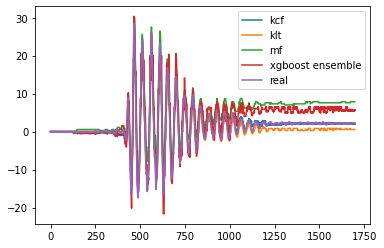

(8.935696321246397, 2.989263508164912, 2.4256026389698184, 0.9786576468674676)

In [26]:
test(tdf1_1, tdf2_1, tdf3_1, model1)

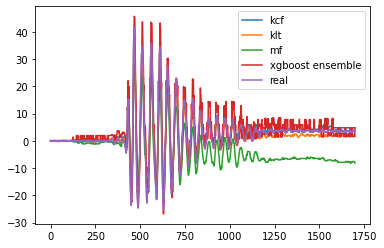

(10.012509636571169,
 3.1642549891832625,
 2.2749308356401308,
 0.8524395863201915)

In [27]:
test(tdf1_2, tdf2_2, tdf3_2, model2)

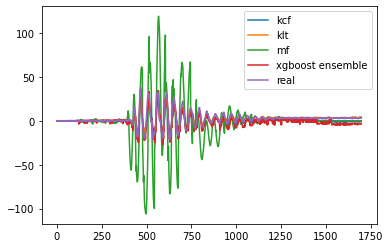

(20.91160604196971, 4.572920952954436, 3.548844986284265, 1.2709614588002205)

In [28]:
test(tdf1_3, tdf2_3, tdf3_3, model3)